Units used: GeV for masses, s for time, cm for distances

In [1]:
import os
import glob
import importlib

import matplotlib as mlib
import matplotlib.pyplot as plt

# plt.rcParams["text.usetex"] = True
# plt.rcParams["text.latex.preamble"] = r"\usepackage{slashed}"

import numpy as np
from numpy import genfromtxt
from numpy import loadtxt
import re
import csv
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


import sys
sys.path.insert(1, '/home/stasya/prj/alps-running/TdAlps-Internal/')
import TdAlps
from collections import OrderedDict

import scipy
import scipy.integrate as integrate
import scipy.optimize as optimize

import csv

In [2]:
#Plotting settings

font = {
        'weight' : 'normal',
        'size'   : 16}

mlib.rc('font', **font)

In [3]:
def importNotebook(name):
    
    currentDir=os.getcwd()
    notebookDir=os.path.dirname(name)
    os.chdir(notebookDir)
    notebookName=os.path.basename(name).split('.')[0]
    module = importlib.import_module(f"ipynb.fs.full.{notebookName}")
    
    os.chdir(currentDir)
    
    globals().update(vars(module))

In [4]:
importNotebook("/home/stasya/prj/alps/Python/ALPs_base.ipynb")

(-0.0009388126244052196-3.3337853215396413e-29j)


/home/stasya/prj/alps/Python/ALPs_base.ipynb:641: ComplexWarning: Casting complex values to real discards the imaginary part
  "\n",
/home/stasya/prj/alps/Python/ALPs_base.ipynb:681: ComplexWarning: Casting complex values to real discards the imaginary part
  "    return float(gamma)\n",
/home/stasya/prj/alps/Python/ALPs_base.ipynb:694: ComplexWarning: Casting complex values to real discards the imaginary part
  "    alphaEM = readAlphaEM(coeffs)\n",
/home/stasya/prj/alps/Python/ALPs_base.ipynb:668: ComplexWarning: Casting complex values to real discards the imaginary part
  {


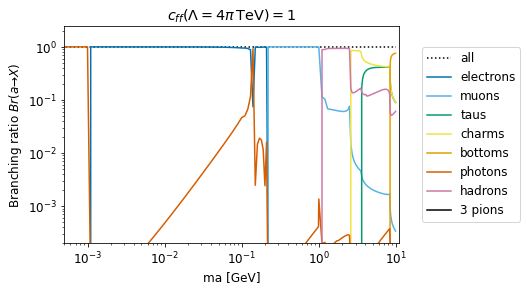

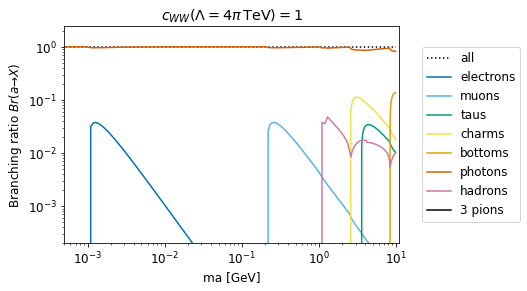

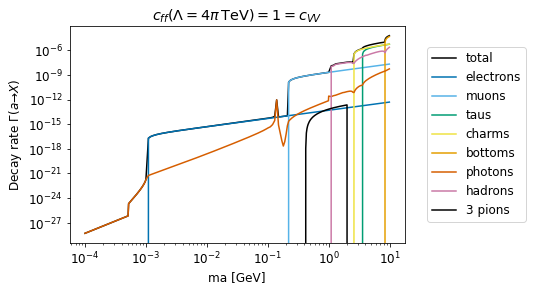

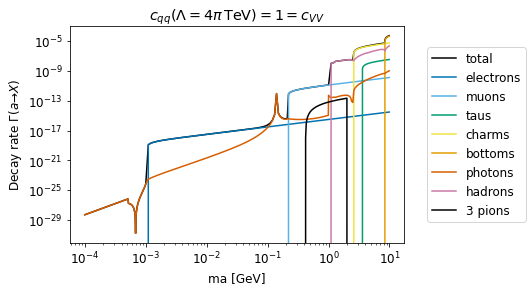

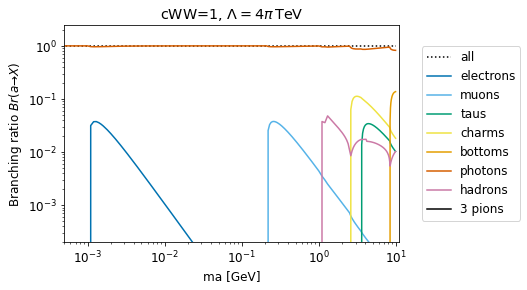

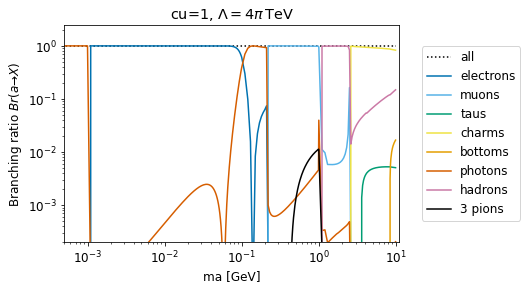

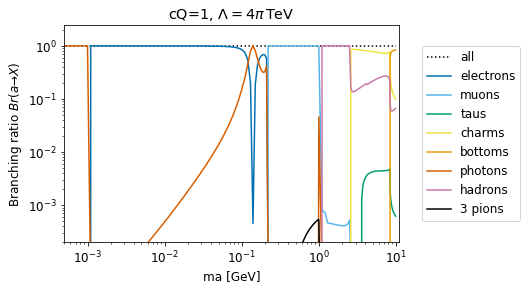

KeyboardInterrupt: 

In [5]:
importNotebook("/home/stasya/prj/alps/Python/ALPs_BRs.ipynb")

### mass-coupling grid

In [ ]:
#masslist= [0.05, 0.05, 0.1, 0.2, 0.3, 0.5, 1., 2., 4.]
masslist=np.sort(np.append(np.logspace(-2, 0, 25),[0.09, 0.101, 0.43, 0.47,0.55,\
                                                   0.95, 1, 1.5, 2, 2.5, 3, 3.2, 3.5, 4,\
                                                   0.0935, 0.095, 0.63, 0.65]))
masslistShort=np.logspace(-2,np.log(2.1), 40)
masslistcWWcheck= np.linspace(0.3,0.4,1)
particleCodes=[*range(0,7,1)]

In [ ]:
masslistcWWcheck

In [ ]:
couplingList=np.sort(np.append(np.logspace(-6, 4, 20),np.logspace(-1, 2, 20)))
couplingListShort=np.logspace(np.log(8*10**-4), np.log(1.7), 25)
couplingListcWWcheck=np.linspace(0.5,95,10)
couplingListcWWcheckShort=np.array([0.5,1,1.5,2,2,5.3,50,80,85,90,95])

In [ ]:
couplingListcWWcheck

In [ ]:
constants={
    'InvGeVtocm': 1/(5.06 * 10**(13))
}

In [ ]:
sm['tauB+'] = 1.638*10**(-12)
sm['ctauB+']= 3 * 10**10 * 1.638*10**(-12)

## based on https://github.com/rrschaefer/alps (formulas taken from 2012.12272 and 1708.00443)

### Alps running implemented in https://github.com/TdAlps

### ALP and B-> Ka decay rates

In [ ]:
def BrBtoKaplus(ma, cbs, Lambda):
    return (np.pi/4)*abs(cbs)**2/(Lambda**2) * abs(formFactorFzeroBplus(ma**2))**2 \
            * (sm['mB+']**2-sm['mK+']**2)**2/sm['mB+']**3 * np.sqrt(sm['mB+']**4+sm['mK+']**4+ma**4\
            -2*(sm['mB+']**2 * sm['mK+']**2 + sm['mK+']**2 * ma**2 + ma**2 * sm['mB+']**2))\
            /sm['hbar']*sm['tauB+']

### ALP branching ratios

### decays under consideration encoded as
 - 0: e 
 - 1: mu
 - 2: tau
 - 3: charm
 - 4: bottom
 - 5: photon
 - 6: hadron
 - 7: 3 pions

In [ ]:
def brALPtoOneFinalState(ma,finalStateCode,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda,lscsPassed=None):
    with HiddenPrints():
        HC = OrderedDict()
        HC['Q'] = np.array([[cQ,0,0],[0,cQ,0],[0,0,cQ]])
        HC['u'] = -np.array([[cu,0,0],[0,cu,0],[0,0,cu]])
        HC['d'] = -np.array([[cd,0,0],[0,cd,0],[0,0,cd]])
        HC['L'] = np.array([[cL,0,0],[0,cL,0],[0,0,cL]])
        HC['e'] = -np.array([[ce,0,0],[0,ce,0],[0,0,ce]])
        HC['GG'] = cGG
        HC['WW'] = cWW
        HC['BB'] = cBB

        brs = [[],[],[],[],[],[],[],[],[]]
        
        if (lscsPassed is not None):
            lscs=lscsPassed
        else:
            if ma<1:
                mu = 1
            else:
                mu=ma
            lscs = TdAlps.RunRotateMatchRun(HC, Lambda, mu, 3)
        
#         print("mu= ",mu)
#         print("readCee= ",readCee(lscs),", readCmumu= ",readCmumu(lscs))
#         print([ma,readCee(lscs),sm['me'],Lambda])
#         print("Gamma_ll= ",Gammaatoll(ma,readCee(lscs),sm['me'],Lambda))
        
        brs[0].append(Gammaatoll(ma,readCee(lscs),sm['me'],Lambda))
        brs[1].append(Gammaatoll(ma,readCmumu(lscs),sm['mmu'],Lambda))
        try:
            ctautau = readCtautau(lscs)
        except IndexError:
            ctautau = 0
        brs[2].append(Gammaatoll(ma,ctautau,sm['mtau'],Lambda))
        try:
            ccc = readCcc(lscs)
        except IndexError:
            ccc = 0
        brs[3].append(Gammaatoqq(ma,ccc,sm['mc'],Lambda))
        try:
            cbb = readCbb(lscs)
        except IndexError:
            cbb = 0
        brs[4].append(Gammaatoqq(ma,cbb,sm['mb'],Lambda))
        brs[5].append(Gammaatogamgam(ma,lscs,Lambda))
        brs[6].append(Gammaatohad(ma,lscs,Lambda))
        brs[7].append(Gammaato3pi000(ma,lscs,Lambda)+Gammaato3pi0pm(ma,lscs,Lambda))
        brs[8].append(brs[0][-1]+brs[1][-1]+brs[2][-1]+brs[3][-1]+brs[4][-1]+brs[5][-1]\
                      +brs[6][-1]+brs[7][-1])
            

#         print("br[0][-1]= ",brs[0][-1])
        
        ctauAlp=constants['InvGeVtocm']/brs[8][-1]

        return [brs[finalStateCode][-1]/brs[8][-1],ctauAlp]

## Generate [ma, tau, c, BR(theory)] files

In [ ]:
masslist

In [ ]:
couplingList

In [ ]:
def generateLHCbFiles(mlist,clist,process,Lambda):
    
    with HiddenPrints():
    
        lhcbList=[['# m [GeV], tau [ps], c, BR_theo(B->K mu mu)\n']]
#         print("start")

        for ma in mlist:
            for c in clist:

#                 if process in ['cff=cWW=cBB']:
#                     #print("1")
#                     cQ=cL=cWW=cBB=cff=c
#                     ce=cd=cu=-c
#                     cGG=0

                if process in ['cWW']:
                    #print("2")
                    cQ=cL=cu=cd=ce=cGG=cBB=cff=0
                    cWW=c


                if process in ['cff']:
                    #print("3")
                    cGG=cWW=cBB=0
                    cQ=cL=cff=c
                    ce=cd=cu=c

                coefs=getLScoefficients(cff, cWW, cBB, Lambda, ma)
                cbs=getCbs(cff, cWW, cBB, Lambda, sm['mB+'])
#                 print("ma= ",ma,", cff= ",cff,", cWW= ",cWW,", cBB= ",cBB,", cbs= ",cbs)

                BR= BrBtoKaplus(ma, cbs, Lambda) \
                *brALPtoOneFinalState(ma,1,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda,None)[0]
                tau=ctaua(ma, cff, cWW, cBB, Lambda)/sm['c']*10**12

                lhcbList.append([ma,tau,c,BR])
        return lhcbList

In [ ]:
meshcWWcheckShort=generateLHCbFiles(masslistcWWcheck,couplingListcWWcheckShort,'cWW',4*np.pi*10**3)

In [ ]:
with open("output/m-tau-c-BRBtoKmumu-cWWcheckShort.dat", "w", newline="") as f:
    writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
    writer.writerows(meshcWWcheckShort)

In [17]:
meshcWW=generateLHCbFiles(masslist,couplingList,'cWW',4*np.pi*10**3)
meshcff=generateLHCbFiles(masslist,couplingList,'cff',4*np.pi*10**3)

In [20]:
        
with open("output/m-tau-c-BRBtoKmumu-cWW.dat", "w", newline="") as f:
    writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
    writer.writerows(meshcWW)
    
with open("output/m-tau-c-BRBtoKmumu-cff.dat", "w", newline="") as f:
    writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
    writer.writerows(meshcff)